In [52]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model
from joblib import load
import joblib
import shutil
from collections import Counter

# Se predicen resultados primero individuales y luego genera 3 carpetas

Una de graficas reales que grafica todo los datos que se tienen en graficas individuales, luego una que grafica graficas predichas, que predice con el modelo cargado al principio, la tercera compara las 2 pasadas

Carga del modelo normalizado

In [53]:
model = tf.keras.models.load_model('h5/EXPERIMENT.h5')

# Especificando los valores a usar

In [54]:
fracvol =  5
radio = 50
espesor = 100
longitud_de_onda = list(range(301, 901))

Creando diccionario

In [55]:
data = {
    "Longitud de onda": longitud_de_onda,
    "Fracvol": [fracvol] * len(longitud_de_onda),
    "Radio (nm)": [radio] * len(longitud_de_onda),
    "Espesor de la película (nm)": [espesor] * len(longitud_de_onda)
}

Creando DF

In [56]:
df  = pd.DataFrame(data)
df

,Longitud de onda,Fracvol,Radio (nm),Espesor de la película (nm)
0,301,5,50,100
1,302,5,50,100
2,303,5,50,100
3,304,5,50,100
4,305,5,50,100
...,...,...,...,...
595,896,5,50,100
596,897,5,50,100
597,898,5,50,100
598,899,5,50,100


Normalizando valores

In [57]:
scaler_X = joblib.load('minmax_scaler_X.pkl')
x = df.values
x_norm = scaler_X.transform(x)

# Predicciones

In [58]:
predictions = model.predict(x_norm)

19/19 [==============================] - 0s 622us/step


In [59]:
df1 = pd.DataFrame(df, columns = ['Longitud de onda', 'Fracvol', 'Radio (nm)', 'Espesor de la película (nm)'])
df2 = pd.DataFrame(predictions , columns = ['Índice de absorción'])

In [60]:
result_df = pd.concat([df1, df2], axis=1)
result_df

,Longitud de onda,Fracvol,Radio (nm),Espesor de la película (nm),Índice de absorción
0,301,5,50,100,0.003349
1,302,5,50,100,0.003297
2,303,5,50,100,0.003242
3,304,5,50,100,0.003013
4,305,5,50,100,0.002823
...,...,...,...,...,...
595,896,5,50,100,0.004938
596,897,5,50,100,0.004944
597,898,5,50,100,0.004951
598,899,5,50,100,0.004958


# Gráfica con valores normalizados

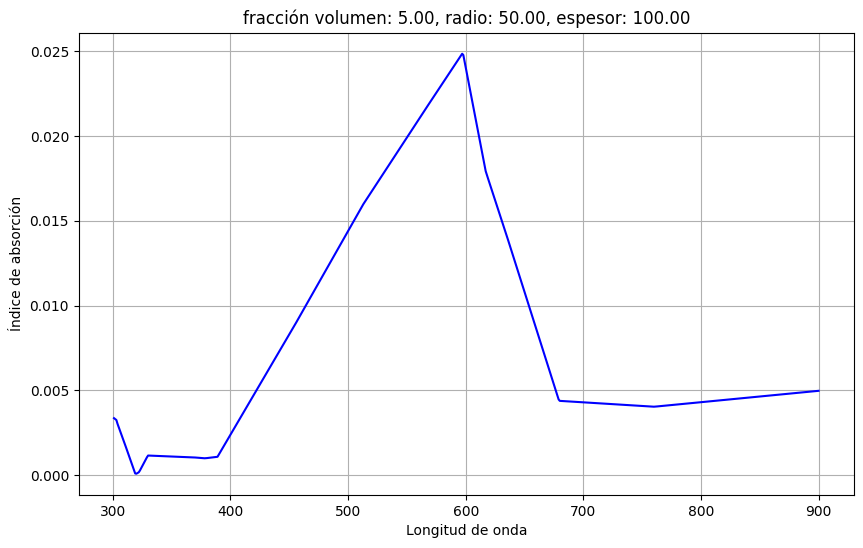

In [61]:
columnas_seleccionadas = ['Longitud de onda', 'Índice de absorción']
df_seleccionado = result_df[columnas_seleccionadas]
titulo = 'fracción volumen: {:.2f}, radio: {:.2f}, espesor: {:.2f}'.format(fracvol, radio, espesor)

# Crear la gráfica de dispersión
plt.figure(figsize=(10, 6))
plt.plot(df_seleccionado['Longitud de onda'], df_seleccionado['Índice de absorción'], color='blue')
plt.xlabel('Longitud de onda')
plt.ylabel('Índice de absorción')
plt.title(titulo)
plt.grid(True)
plt.show()

# Haciendolo con varias gráficas a la vez

Funcion que genera y guarda imagenes generadas

In [62]:
files = [file for file in os.listdir('./parametros')]

param = pd.DataFrame()
for file in files:
  df = pd.read_csv('./parametros/'+file)
  param = pd.concat([param, df], axis= 0)

In [63]:
combinaciones_unicas = param[['Fracvol', 'Radio (nm)', 'Espesor de la película (nm)']].drop_duplicates().reset_index(drop=True)
combinaciones_filtradas = combinaciones_unicas[combinaciones_unicas['Fracvol'] <= 3].reset_index(drop=True)

In [64]:
fracvol = combinaciones_filtradas['Fracvol'].tolist()
radio = combinaciones_filtradas['Radio (nm)'].tolist()
espesor = combinaciones_filtradas['Espesor de la película (nm)'].tolist()
longitud_de_onda = list(range(301, 901))

Borrando carpetas para que no se dupliquen

In [65]:
# Ruta del directorio
dir_path = 'graficas_reales'

# Si el directorio ya existe, eliminarlo
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)

# Crear el directorio
os.makedirs(dir_path)

In [66]:
# Asegurarse de que la carpeta graficas_reales exista
if not os.path.exists('graficas_reales'):
    os.makedirs('graficas_reales')

# Iterar sobre las combinaciones únicas y filtradas
for f, r, e in zip(fracvol, radio, espesor):
    # Filtrar el dataframe params para obtener datos que coincidan con la combinación actual
    subset = param[(param['Fracvol'] == f) & 
                    (param['Radio (nm)'] == r) & 
                    (param['Espesor de la película (nm)'] == e)]
    
    # Si hay menos de 600 datos para esta combinación, saltar a la siguiente iteración
    if len(subset) < 600:
        continue

    # Crear la gráfica de dispersión para esta combinación
    plt.figure(figsize=(10, 6))
    plt.plot(subset['Longitud de onda'], subset['Índice de absorción'], color='blue')
    plt.xlabel('Longitud de onda')
    plt.ylabel('Índice de absorción')
    titulo = 'fracción volumen: {:.2f}, radio: {:.2f}, espesor: {:.2f}'.format(f, r, e)
    plt.title(titulo)
    plt.grid(True)
    filename = 'graficas_reales/grafica_{:.2f}_{:.2f}_{:.2f}.png'.format(f, r, e)
    plt.savefig(filename)
    plt.close()




In [67]:
# Ruta del directorio
dir_path = 'graficas_predichas'

# Si el directorio ya existe, eliminarlo
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)

# Crear el directorio
os.makedirs(dir_path)

In [68]:
# Asegurar que la carpeta existe o crearla
carpeta = "graficas_predichas"
if not os.path.exists(carpeta):
    os.mkdir(carpeta)

# Asumiendo que todos los arrays (fracvol, radio, espesor) tienen la misma longitud:
num_elementos = len(fracvol)

scaler_X = load('minmax_scaler_X.pkl')

for i in range(num_elementos):
    data = {
        "Longitud de onda": longitud_de_onda,
        "Fracvol": [fracvol[i]] * len(longitud_de_onda),
        "Radio (nm)": [radio[i]] * len(longitud_de_onda),
        "Espesor de la película (nm)": [espesor[i]] * len(longitud_de_onda)
    }
    
    df = pd.DataFrame(data)
    x = df.values
    x_norm = scaler_X.transform(x)
    predictions = model.predict(x_norm)

    df["Índice de absorción"] = predictions

    columnas_seleccionadas = ['Longitud de onda', 'Índice de absorción']
    df_seleccionado = df[columnas_seleccionadas]
    titulo = 'fracción volumen: {:.2f}, radio: {:.2f}, espesor: {:.2f}'.format(fracvol[i], radio[i], espesor[i])

    # Crear la gráfica de dispersión
    plt.figure(figsize=(10, 6))
    plt.plot(df_seleccionado['Longitud de onda'], df_seleccionado['Índice de absorción'], color='blue')
    plt.xlabel('Longitud de onda')
    plt.ylabel('Índice de absorción')
    plt.title(titulo)
    plt.grid(True)
    
    # Guardar la gráfica como imagen en la carpeta especificada
    nombre_archivo = os.path.join(carpeta, "grafica_{}_{}_{}.png".format(fracvol[i], radio[i], espesor[i]))
    plt.savefig(nombre_archivo)
    plt.close()

19/19 [==============================] - 0s 611us/step


19/19 [==============================] - 0s 500us/step


In [69]:
longitud_de_onda = list(range(300, 900))

In [70]:
len(longitud_de_onda)

600

Borrando carpetas si ya existen

In [71]:
# Ruta del directorio
dir_path = 'comparacion_de_datos'

# Si el directorio ya existe, eliminarlo
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)

# Crear el directorio
os.makedirs(dir_path)

# Lista para almacenar los errores MSE
errores_mse = []

Solo guarda las graficas con errores menores a 2.5611e-06, que fue el error medio cuando tomamos en cuenta todos los valores.
Se está utilizando la regla del trapecio, se divide el area bajo la curva en una serie de trapecios y luego se suma para calcular el total. AUC = area bajo la curva, en un rango de 400 a 700 nm, nos dice cuánta absorción hay

In [72]:
# Iteramos sobre todas las combinaciones posibles de fracvol, radio y espesor
for f, r, e in zip(fracvol, radio, espesor):
    
    # Filtrar el dataframe `param` para obtener los datos reales asociados con esa combinación
    subset = param[(param['Fracvol'] == f) & 
                   (param['Radio (nm)'] == r) & 
                   (param['Espesor de la película (nm)'] == e)]
    
    # Si hay menos de 600 datos o más de 600, saltamos a la siguiente iteración
    if len(subset) != 600:
        continue

    # Extraer la 'Longitud de onda' y el 'Índice de absorción'
    X_real = subset[['Longitud de onda', 'Fracvol', 'Radio (nm)', 'Espesor de la película (nm)']].values
    y_real = subset['Índice de absorción'].values

    # Hacer las predicciones con el modelo
    y_pred = model.predict(scaler_X.transform(X_real))

    # Calcular el MSE y agregarlo a la lista
    mse = mean_squared_error(y_real, y_pred)
    errores_mse.append(mse)
    y_pred = y_pred.ravel()
    longitud_de_onda = np.array(longitud_de_onda)
    
    # Calcular el AUC para el rango de 400 a 700 nm
    mask = (X_real[:, 0] >= 400) & (X_real[:, 0] <= 700)
    auc_real = np.trapz(y_real[mask], X_real[mask, 0])
    auc_pred = np.trapz(y_pred[mask], X_real[mask, 0])

    # Guardar la figura en la carpeta "comparacion_de_datos" si el MSE es menor al límite
    if mse <= 2.5547e-06:
        # Graficar las curvas reales y predichas
        plt.figure(figsize=(10, 6))
        plt.plot(longitud_de_onda, y_real, label='Real', color='blue')
        plt.plot(longitud_de_onda, y_pred, label='Predicción', color='red', linestyle='--')
        plt.xlabel('Longitud de onda')
        plt.ylabel('Índice de absorción')
        plt.title(f'Real vs Predicha - Fracvol: {f}, Radio: {r} nm, Espesor: {e} nm. MSE: {mse:.4e},\n AUC Real: {auc_real:.4e}, AUC Pred: {auc_pred:.4e}')
        plt.legend()
        filename = f"Comparacion_Fracvol_{f}_Radio_{r}nm_Espesor_{e}nm.png"
        plt.savefig(os.path.join(dir_path, filename))
        plt.close()  # Cerrar la figura actual para no llenar la memoria

# Calcular el promedio de todos los MSEs
mse_promedio = sum(errores_mse) / len(errores_mse)
print(f"El MSE promedio es: {mse_promedio:.4e}")

19/19 [==============================] - 0s 605us/step


19/19 [==============================] - 0s 868us/step
El MSE promedio es: 2.5611e-06
